# About the Notebook

In this notebook, we have performed data augmentation for both training and test set. We then run our models on this data and note their performance.

## Importing Packages

In [196]:
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
import string
import cv2
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import glob
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import callbacks as cb
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras import layers
from tensorflow.keras import optimizers

## Function for Extracting Images

This code defines a function named `get_middle_images` that extracts a subset of images from each class folder within our data directory. It takes the path to this directory containing class folders as input and returns a pandas DataFrame containing information about the middle subset of images from each class. The function allows specifying a percentage of images to be extracted from the middle of each class folder. Here we extract 30% images from the middle of each class folder

In [155]:
def natural_sort_key(s, _nsre=re.compile('([0-9]+)')):
    return [int(text) if text.isdigit() else text.lower() for text in _nsre.split(s)]

def get_middle_images(path, percentage=0.3):
    labels = []
    images = []
    directories = []
    for directory in os.listdir(path)[:10]:
        for label in os.listdir(os.path.join(path, directory)):
            image_folder = os.path.join(path, directory, label)
            images_list = sorted(os.listdir(image_folder), key=natural_sort_key)
            num_images = len(images_list)
            start_index = int((1 - percentage) / 2 * num_images)
            end_index = int((1 + percentage) / 2 * num_images)
            middle_images = images_list[start_index:end_index]

            for image in middle_images:
                directories.append(directory)
                labels.append(label)
                images.append(os.path.join(directory, label, image))

    return pd.DataFrame({'labels': directories, 'videos': labels, 'images': images})

## Loading the Data

In [156]:
dataset_dir = os.path.abspath('C:\\Users\\HP\\Downloads\\DeepLearningProject\\train\\frames_output')
train_df = get_middle_images(dataset_dir)

In [157]:
dataset_dir2 = os.path.abspath('C:\\Users\\HP\\Downloads\\DeepLearningProject\\test\\frames_output')
test_df = get_middle_images(dataset_dir2)

In [158]:
test_df.shape

(3546, 3)

In [159]:
test_df.head(10)

,labels,videos,images
0,001,001_002_001,001\001_002_001\frame41.jpg
1,001,001_002_001,001\001_002_001\frame42.jpg
2,001,001_002_001,001\001_002_001\frame43.jpg
3,001,001_002_001,001\001_002_001\frame44.jpg
4,001,001_002_001,001\001_002_001\frame45.jpg
5,001,001_002_001,001\001_002_001\frame46.jpg
6,001,001_002_001,001\001_002_001\frame47.jpg
7,001,001_002_001,001\001_002_001\frame48.jpg
8,001,001_002_001,001\001_002_001\frame49.jpg
9,001,001_002_001,001\001_002_001\frame50.jpg


In [160]:
train_df.shape

(14256, 3)

In [162]:
train_df.head(10)

,labels,videos,images
0,001,001_001_001,001\001_001_001\frame30.jpg
1,001,001_001_001,001\001_001_001\frame31.jpg
2,001,001_001_001,001\001_001_001\frame32.jpg
3,001,001_001_001,001\001_001_001\frame33.jpg
4,001,001_001_001,001\001_001_001\frame34.jpg
5,001,001_001_001,001\001_001_001\frame35.jpg
6,001,001_001_001,001\001_001_001\frame36.jpg
7,001,001_001_001,001\001_001_001\frame37.jpg
8,001,001_001_001,001\001_001_001\frame38.jpg
9,001,001_001_001,001\001_001_001\frame39.jpg


## Plotting the frames

This function, `random_sample_plot(X)`, plots a random sample of images from the dataset `X`. It selects 16 random images and displays them in a 4x4 grid along with their corresponding labels. The images are loaded using `load_img` from the dataset directory specified by `dataset_dir`.

In [163]:
def random_sample_plot(X):
    plt.figure(figsize=(15, 18))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        sample = random.choice(X['images'])
        image = load_img(dataset_dir+'/'+sample)
        plt.imshow(image)
        plt.title("label:{},\nimage:{}".format(X[X['images']==sample]['labels'].values,sample))
    plt.show()

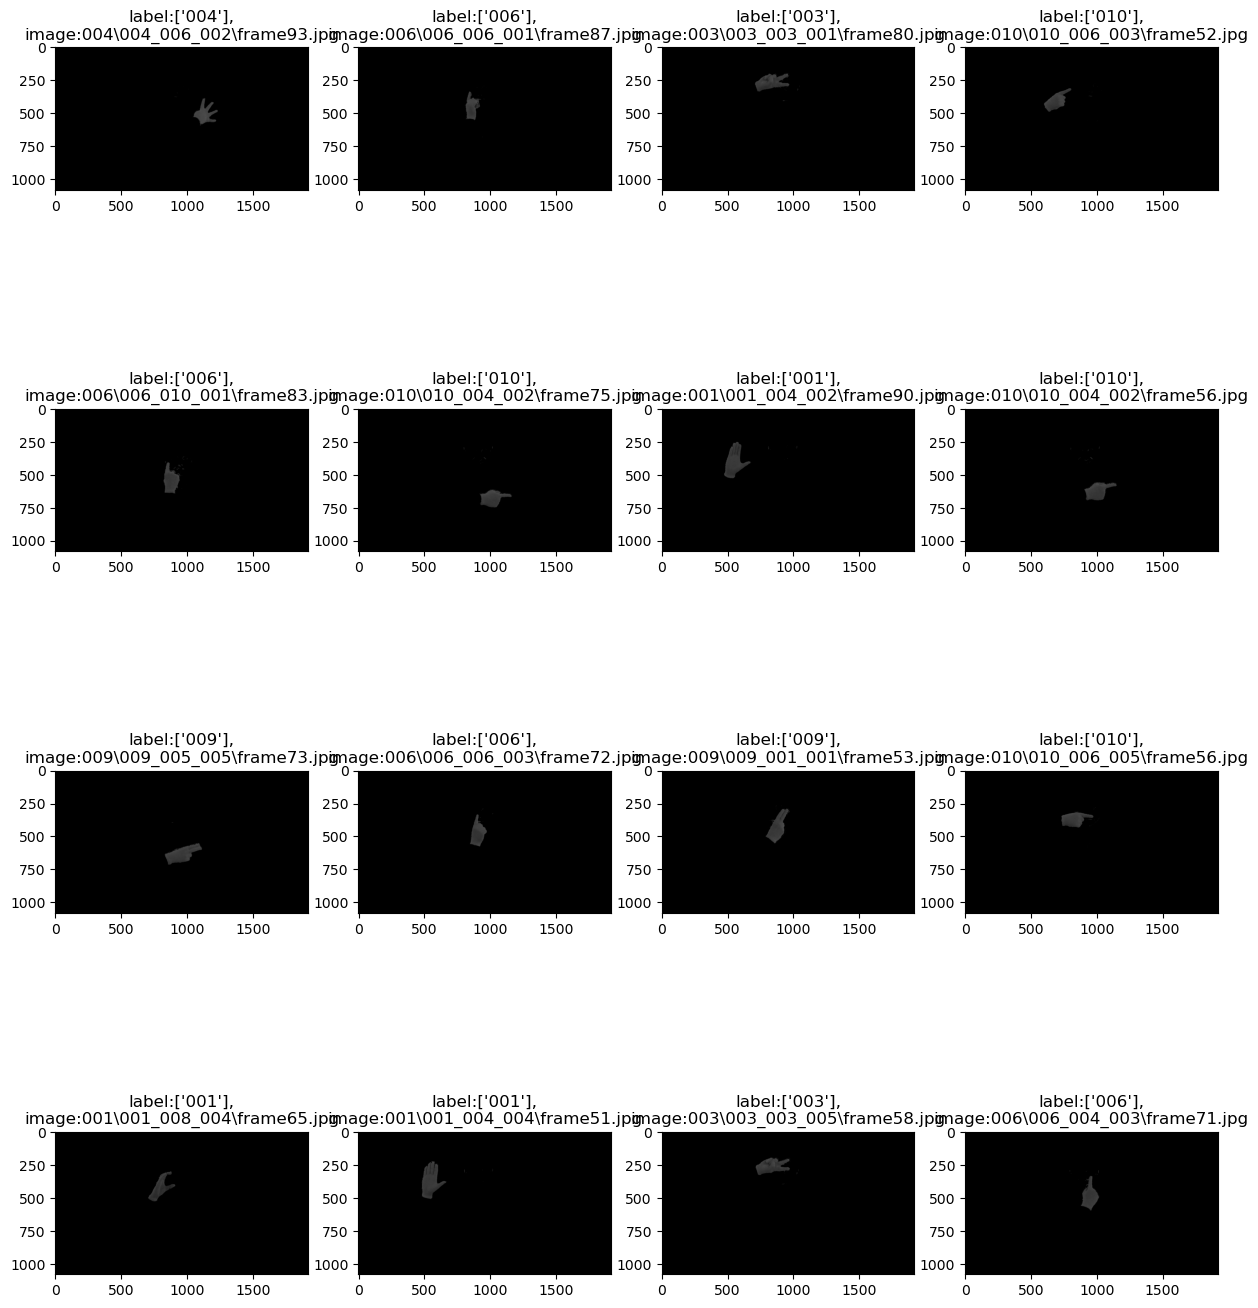

In [164]:
random_sample_plot(train_df)

## Data Augmentation

This code sets up two data generators for image preprocessing and augmentation using the Keras `ImageDataGenerator` class with specified augmentation parameters like rotation_range, shear_range etc. It also defines two callback functions: `EarlyStopping`, which monitors validation loss and stops training when the loss stops decreasing, and `ReduceLROnPlateau`, which reduces the learning rate when the validation loss stops improving. These callbacks are used during model training later in this notebook.

In [ ]:
BATCH_SIZE = 128

In [203]:
data_gen_args1 = dict(
    directory=dataset_dir,
    x_col='images',
    y_col='labels',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    seed=45,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1.0/255
)

data_gen_args2 = dict(
    directory=dataset_dir2,
    x_col='images',
    y_col='labels',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    seed=45,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1.0/255
)

early_stop = cb.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

learningrate_reduction = cb.ReduceLROnPlateau(
    monitor='val_loss',
    patience=2,
    verbose=1,
)

callbacks = [early_stop, learningrate_reduction]

EPOCHS = 10

## Function for image generator

This code below defines a function `define_image_generators(train_df, val_df, test_df)` defines and returns three data generators (`train_generator`, `val_generator`, and `test_generator`) using Keras `flow_from_dataframe` method. These generators are created using the training, validation, and test dataframes, with image augmentation and preprocessing parameters specified in `data_gen_args1` and `data_gen_args2`. Additionally, the function prints the number of batches in the training and validation generators. The `test_generator` is set to not shuffle its data.

In [169]:
def define_image_generators(train_df, val_df, test_df):
    train_generator = datagen.flow_from_dataframe(train_df, **data_gen_args1)
    val_generator = datagen.flow_from_dataframe(val_df, **data_gen_args1)
    test_generator = datagen.flow_from_dataframe(test_df, **data_gen_args2, shuffle = False)
    print("Number of batches in train generator:", len(train_generator))
    print("Number of batches in validation generator:", len(val_generator))
    return train_generator, val_generator, test_generator

## Function for splitting the data

This function `split_data(data1, data2)` takes two datasets (`data1` and `data2`) and splits them into training, validation, and test sets. It splits `data1` into training and validation sets using a 85-15 split, and then assigns `data2` as the test set. After splitting, it prints the number of samples in each split and returns the training, validation, and test sets. The indices of the resulting dataframes are reset for consistency.

In [170]:
def split_data(data1, data2):    
    
    train_df, test_df = data1, data2
    train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=45)
    train_df = train_df.reset_index(drop=True)
    val_df = val_df.reset_index(drop=True)
    test_df = test_df.reset_index(drop=True)
    
    print('----------------------------------------------------------------')
    print("The Number of Samples per Split")
    print('----------------------------------------------------------------')
    print('Number of   training samples : {}'.format(train_df.shape[0]))
    print('Number of validation samples : {}'.format(val_df.shape[0]))
    print('Number of       test samples : {}'.format(test_df.shape[0]))
    print('----------------------------------------------------------------')
    
    return train_df, val_df, test_df

## Function for plotting evaluation metrics

This function `plot_accuracy_loss(history)` takes the `history` object returned by the `model.fit()` function and plots the training and validation accuracy as well as the training and validation loss over epochs. It extracts the accuracy and loss values from the `history` object and then plots them using Matplotlib. The function produces two subplots: one for accuracy and the other for loss.

In [172]:
def plot_accuracy_loss(history):    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize = (10, 7))

    plt.subplot(1,2,1)
    plt.plot(epochs, acc, c = 'b', label = 'Training Accuracy')
    plt.plot(epochs, val_acc, c = 'g', label = 'Validation Accuracy')
    plt.title('Training vs. Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, loss, c = 'b', label = 'Training Loss')
    plt.plot(epochs, val_loss, c = 'g', label = 'Validation Loss')
    plt.title('Training vs. Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

## Function to evaluate model performance

This function `show_accuracy_loss(model, test_generator)` evaluates the trained model's performance against the test data. It prints a classification report showing precision, recall, and F1-score for each class. It also prints evaluation loss and accuracy. The function uses a `class_mapping` dictionary to map class indices to class labels for better readability in the classification report. Finally, it evaluates the model using the `evaluate` method with the test data generator.

In [302]:
class_mapping = {
    0: 'Opaque',
    1: 'Red',
    2: 'Green',
    3: 'Yellow',
    4: 'Bright',
    5: 'Light-Blue',
    6: 'Colors',
    7: 'Pink',
    8: 'Women',
    9: 'Enemy'
}

def show_accuracy_loss(model, test_generator):
    print('---------------Evaluation Against Test Data---------------------')
    predictions = model.predict(test_generator)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_generator.classes
    class_labels = [class_mapping[i] for i in range(len(class_mapping))]  # Use class_mapping here
    
    print(classification_report(y_true, y_pred, target_names=class_labels))
    
    eval_loss, eval_acc = model.evaluate(test_generator)
    print('Evaluation Loss: {:.4f}, Evaluation Accuracy: {:.2f}'.format(eval_loss, eval_acc * 100))
    print('----------------------------------------------------------------')

## Splitting the data into train, test and validation set

In [176]:
train_df, val_df, test_df = split_data(train_df, test_df)

----------------------------------------------------------------
The Number of Samples per Split
----------------------------------------------------------------
Number of   training samples : 12117
Number of validation samples : 2139
Number of       test samples : 3546
----------------------------------------------------------------


## Data Generator Setup

The function call `define_image_generators(train_df, val_df, test_df)` creates three data generators: `train_generator`, `val_generator`, and `test_generator`. These generators are used to load and preprocess images from the specified dataframes.`train_generator` is used for training the model, val_generator is used for validation during training, and test_generator is used to evaluate the trained model's performance on unseen data.

In [177]:
train_generator, val_generator, test_generator = define_image_generators(train_df, val_df, test_df)

Found 12117 validated image filenames belonging to 10 classes.
Found 2139 validated image filenames belonging to 10 classes.
Found 3546 validated image filenames belonging to 10 classes.
Number of batches in train generator: 95
Number of batches in validation generator: 17


## Visualization of Augmented Training Data

This code chunk generates a batch of training data samples (`x_batch`) along with their corresponding labels (`y_batch`) using the `train_generator.next()` method. It then plots a 3x3 grid of images from the batch using Matplotlib. Each subplot displays an image from the batch, and the axis is turned off for better visualization.

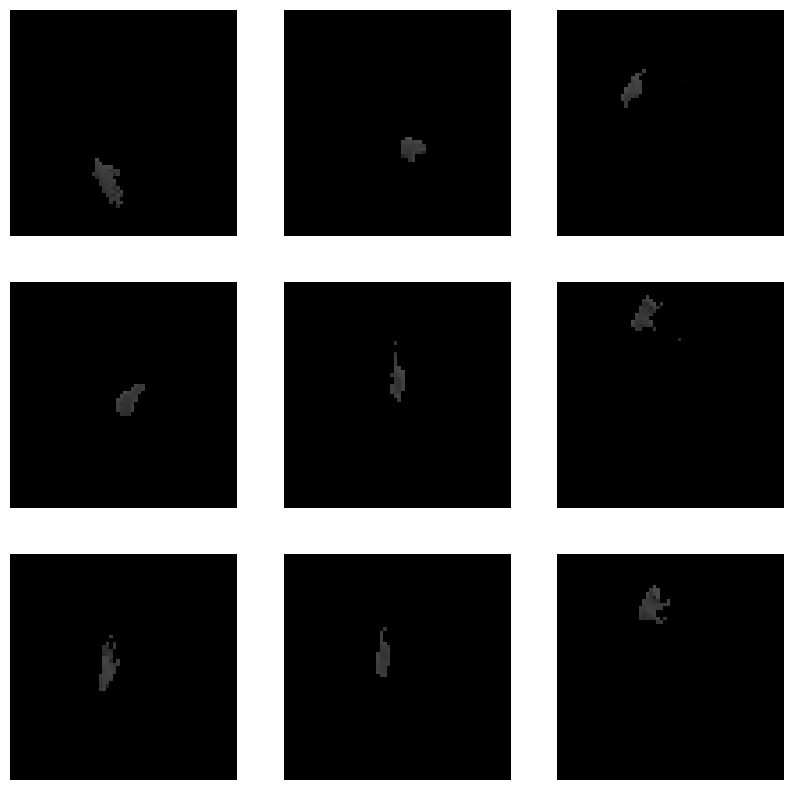

In [178]:
x_batch, y_batch = train_generator.next()

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(x_batch[i])
    plt.axis("off")
plt.show()

## Model 1:

This model uses pre-trained VGG19 as the base model together with seven additional layers and RMSprop optimiser.

### Downloading weights of pre-trained VGG19

In [319]:
import requests

IMAGE_WIDTH = 64
IMAGE_HEIGHT = 64
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS= 3
LABEL_CLASS = 10
LEARNINGRATE = 1e-5

WEIGHTS = 'C:\\Users\\HP\\Downloads\\DeepLearningProject\\train\\vgg19\\vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'

if not os.path.exists(WEIGHTS):
    print("Downloading VGG19 weights...")
    os.makedirs(os.path.dirname(WEIGHTS), exist_ok=True)
    url = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'
    response = requests.get(url)
    with open(WEIGHTS, 'wb') as f:
        f.write(response.content)
    print("Download complete!")

### Model Building

In [171]:
def build_model():
    base = VGG19(include_top = False, weights = WEIGHTS, input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))
    X = base.output
    X = layers.Flatten()(X)
    X = layers.Dense(512, activation = 'relu')(X)
    X = layers.Dropout(0.4)(X)
    X = layers.BatchNormalization()(X)
    X = layers.Dense(512, activation = 'relu')(X)
    X = layers.Dropout(0.3)(X)
    X = layers.BatchNormalization()(X)
    
    # output
    preds = layers.Dense(LABEL_CLASS, activation = 'softmax')(X)
    model = models.Model(inputs = base.input, outputs = preds)
    model.compile(optimizer = optimizers.RMSprop(learning_rate = LEARNINGRATE), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

In [175]:
model = build_model()
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

### Model Training

In [179]:
history = model.fit(train_generator,
                    epochs = EPOCHS,
                    validation_data = val_generator,
                    callbacks = callbacks)

Epoch 1/10
95/95 [==============================] - 678s 7s/step - loss: 1.7023 - accuracy: 0.4386 - val_loss: 1.4388 - val_accuracy: 0.7513 - lr: 1.0000e-05
Epoch 2/10
95/95 [==============================] - 665s 7s/step - loss: 0.7476 - accuracy: 0.7619 - val_loss: 0.7816 - val_accuracy: 0.8373 - lr: 1.0000e-05
Epoch 3/10
95/95 [==============================] - 689s 7s/step - loss: 0.4219 - accuracy: 0.8712 - val_loss: 0.3460 - val_accuracy: 0.9135 - lr: 1.0000e-05
Epoch 4/10
95/95 [==============================] - 683s 7s/step - loss: 0.3094 - accuracy: 0.9030 - val_loss: 0.3038 - val_accuracy: 0.9000 - lr: 1.0000e-05
Epoch 5/10
95/95 [==============================] - 679s 7s/step - loss: 0.2411 - accuracy: 0.9237 - val_loss: 0.2851 - val_accuracy: 0.9088 - lr: 1.0000e-05
Epoch 6/10
95/95 [==============================] - 668s 7s/step - loss: 0.2035 - accuracy: 0.9319 - val_loss: 0.1645 - val_accuracy: 0.9378 - lr: 1.0000e-05
Epoch 7/10
95/95 [==============================] - 

### Model Prediction

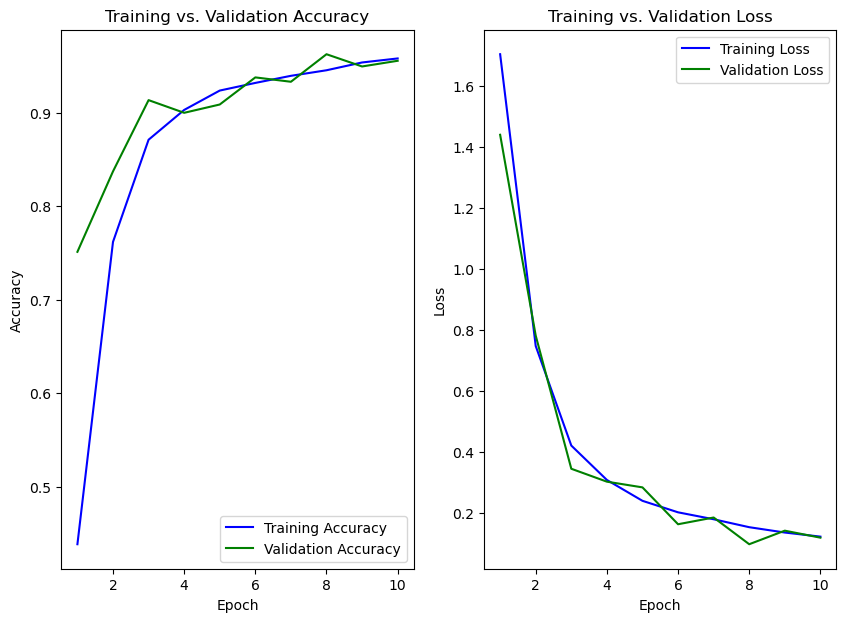

---------------Evaluation Against Test Data---------------------
28/28 [==============================] - 86s 3s/step
              precision    recall  f1-score   support

         001       0.98      0.99      0.99       357
         002       1.00      1.00      1.00       372
         003       0.99      1.00      1.00       344
         004       0.98      0.95      0.97       310
         005       0.97      0.99      0.98       401
         006       0.88      1.00      0.94       455
         007       0.77      0.82      0.79       343
         008       0.91      0.95      0.93       286
         009       1.00      0.97      0.98       368
         010       0.98      0.69      0.81       310

    accuracy                           0.94      3546
   macro avg       0.95      0.94      0.94      3546
weighted avg       0.95      0.94      0.94      3546

28/28 [==============================] - 77s 3s/step - loss: 0.1883 - accuracy: 0.9419
Evaluation Loss: 0.1883, Evaluation 

In [180]:
pipeline = Pipeline(steps=[('plot_accuracy_loss',plot_accuracy_loss(history)),
                                  ('show_accuracy_loss',show_accuracy_loss(model, test_generator))])

## Model3 

This model has VGG19 as the base layer together with seven additional layers and Adam optimiser.

### Model Building

In [183]:
def build_model3():
    base = VGG19(include_top = False, weights = WEIGHTS, input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))
    X = base.output
    X = layers.Flatten()(X)
    X = layers.Dense(512, activation = 'relu')(X)
    X = layers.Dropout(0.4)(X)
    X = layers.BatchNormalization()(X)
    X = layers.Dense(512, activation = 'relu')(X)
    X = layers.Dropout(0.3)(X)
    X = layers.BatchNormalization()(X)
    
    # output
    preds = layers.Dense(LABEL_CLASS, activation = 'softmax')(X)
    model = models.Model(inputs = base.input, outputs = preds)
    model.compile(optimizer = optimizers.Adam(learning_rate = LEARNINGRATE), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

In [184]:
model3 = build_model3()
model3.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

### Model Training

In [185]:
history3 = model3.fit(train_generator,
                    epochs = EPOCHS,
                    validation_data = val_generator,
                    callbacks = callbacks)

Epoch 1/10
95/95 [==============================] - 694s 7s/step - loss: 1.7097 - accuracy: 0.4351 - val_loss: 1.6380 - val_accuracy: 0.6723 - lr: 1.0000e-05
Epoch 2/10
95/95 [==============================] - 680s 7s/step - loss: 0.6404 - accuracy: 0.8026 - val_loss: 0.6735 - val_accuracy: 0.9219 - lr: 1.0000e-05
Epoch 3/10
95/95 [==============================] - 686s 7s/step - loss: 0.3480 - accuracy: 0.9006 - val_loss: 0.2924 - val_accuracy: 0.9369 - lr: 1.0000e-05
Epoch 4/10
95/95 [==============================] - 684s 7s/step - loss: 0.2767 - accuracy: 0.9159 - val_loss: 0.1880 - val_accuracy: 0.9462 - lr: 1.0000e-05
Epoch 5/10
95/95 [==============================] - 681s 7s/step - loss: 0.2089 - accuracy: 0.9360 - val_loss: 0.1089 - val_accuracy: 0.9663 - lr: 1.0000e-05
Epoch 6/10
95/95 [==============================] - 682s 7s/step - loss: 0.1756 - accuracy: 0.9444 - val_loss: 0.0908 - val_accuracy: 0.9668 - lr: 1.0000e-05
Epoch 7/10
95/95 [==============================] - 

### Model Prediction

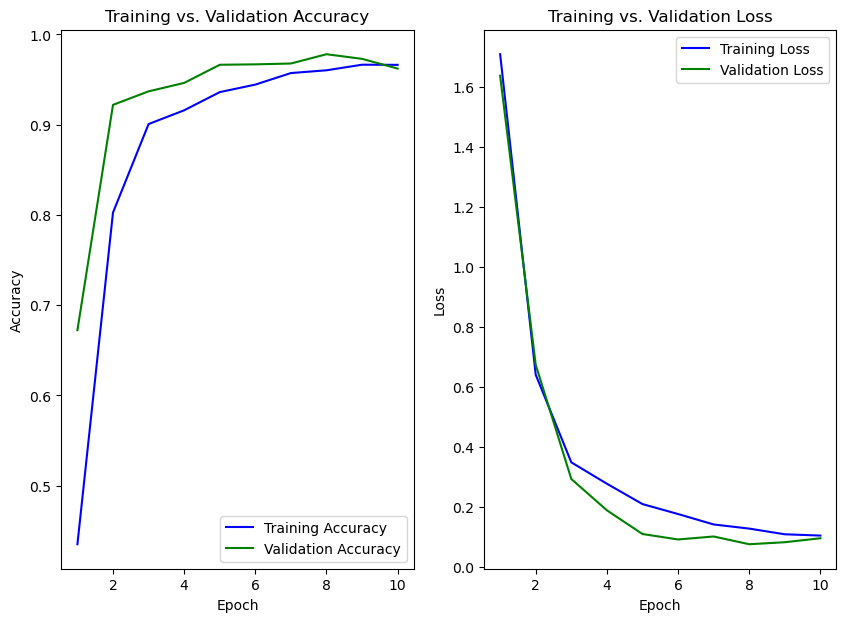

---------------Evaluation Against Test Data---------------------
28/28 [==============================] - 77s 3s/step
              precision    recall  f1-score   support

         001       0.87      0.99      0.93       357
         002       1.00      1.00      1.00       372
         003       1.00      1.00      1.00       344
         004       0.98      0.91      0.94       310
         005       0.96      0.99      0.97       401
         006       0.92      1.00      0.96       455
         007       0.84      0.85      0.84       343
         008       0.87      0.96      0.91       286
         009       1.00      0.97      0.98       368
         010       0.96      0.65      0.77       310

    accuracy                           0.94      3546
   macro avg       0.94      0.93      0.93      3546
weighted avg       0.94      0.94      0.94      3546

28/28 [==============================] - 77s 3s/step - loss: 0.1874 - accuracy: 0.9380
Evaluation Loss: 0.1874, Evaluation 

In [186]:
pipeline = Pipeline(steps=[('plot_accuracy_loss',plot_accuracy_loss(history3)),
                                  ('show_accuracy_loss',show_accuracy_loss(model3, test_generator))])

## Model 4 

This model uses VGG16 as the base model with seven additional layers and Adam optimiser.

In [197]:
from tensorflow.keras.applications import VGG16

### Downloading weights for pre-trained VGG16

In [198]:
# Path to save the weights
W_VGG16 = 'C:\\Users\\HP\\Downloads\\DeepLearningProject\\train\\vgg16\\vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

if not os.path.exists(W_VGG16):
    print("Downloading VGG16 weights...")
    os.makedirs(os.path.dirname(W_VGG16), exist_ok=True)
    url = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
    response = requests.get(url)
    with open(W_VGG16, 'wb') as f:
        f.write(response.content)
    print("Download complete!")

### Model Building

In [199]:
def build_model4():
    base = VGG16(include_top = False, weights = W_VGG16, input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))
    X = base.output
    X = layers.Flatten()(X)
    X = layers.Dense(512, activation = 'relu')(X)
    X = layers.Dropout(0.4)(X)
    X = layers.BatchNormalization()(X)
    X = layers.Dense(512, activation = 'relu')(X)
    X = layers.Dropout(0.3)(X)
    X = layers.BatchNormalization()(X)
    
    preds = layers.Dense(LABEL_CLASS, activation = 'softmax')(X)
    model = models.Model(inputs = base.input, outputs = preds)
    model.compile(optimizer = optimizers.Adam(learning_rate = LEARNINGRATE), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

In [200]:
model4 = build_model4()
model4.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0  

### Model Training

In [204]:
history4 = model4.fit(train_generator,
                    epochs = EPOCHS,
                    validation_data = val_generator,
                    callbacks = callbacks)

Epoch 1/10
95/95 [==============================] - 2138s 22s/step - loss: 1.9079 - accuracy: 0.3778 - val_loss: 1.8243 - val_accuracy: 0.5811 - lr: 1.0000e-05
Epoch 2/10
95/95 [==============================] - 3459s 36s/step - loss: 0.7764 - accuracy: 0.7498 - val_loss: 0.9026 - val_accuracy: 0.9102 - lr: 1.0000e-05
Epoch 3/10
95/95 [==============================] - 2306s 24s/step - loss: 0.4098 - accuracy: 0.8767 - val_loss: 0.3738 - val_accuracy: 0.9434 - lr: 1.0000e-05
Epoch 4/10
95/95 [==============================] - 1604s 17s/step - loss: 0.2767 - accuracy: 0.9143 - val_loss: 0.1781 - val_accuracy: 0.9579 - lr: 1.0000e-05
Epoch 5/10
95/95 [==============================] - 946s 10s/step - loss: 0.2079 - accuracy: 0.9354 - val_loss: 0.1207 - val_accuracy: 0.9621 - lr: 1.0000e-05
Epoch 6/10
95/95 [==============================] - 953s 10s/step - loss: 0.1714 - accuracy: 0.9478 - val_loss: 0.0945 - val_accuracy: 0.9719 - lr: 1.0000e-05
Epoch 7/10
95/95 [========================

### Model Prediction

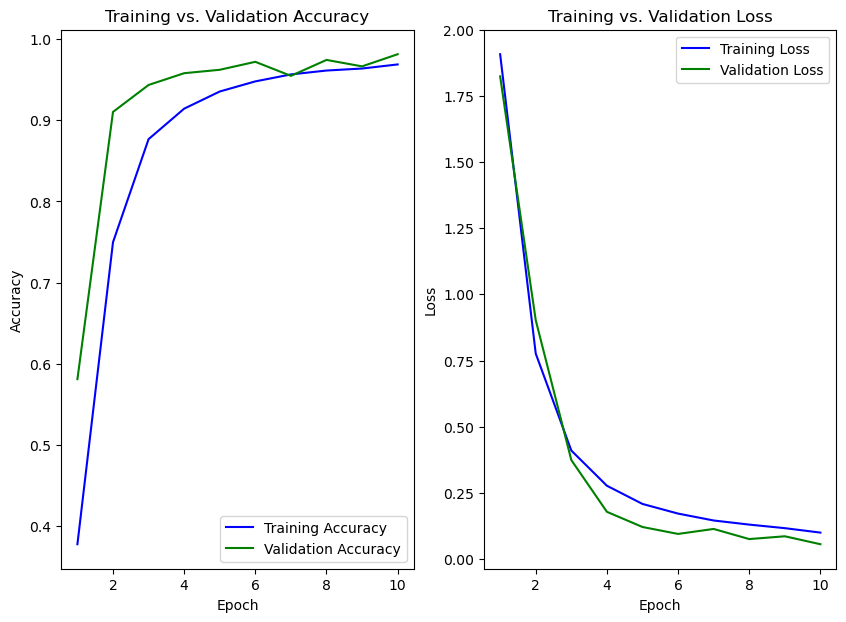

---------------Evaluation Against Test Data---------------------
28/28 [==============================] - 24s 832ms/step
              precision    recall  f1-score   support

      Opaque       0.94      0.99      0.97       357
         Red       1.00      1.00      1.00       372
       Green       1.00      1.00      1.00       344
      Yellow       0.99      0.91      0.95       310
      Bright       0.99      0.96      0.98       401
  Light-Blue       0.91      1.00      0.95       455
      Colors       0.90      0.83      0.87       343
        Pink       0.91      0.99      0.95       286
       Women       0.99      0.98      0.99       368
       Enemy       0.93      0.88      0.91       310

    accuracy                           0.96      3546
   macro avg       0.96      0.95      0.96      3546
weighted avg       0.96      0.96      0.96      3546

28/28 [==============================] - 24s 847ms/step - loss: 0.1460 - accuracy: 0.9574
Evaluation Loss: 0.1460, Evalu

In [304]:
pipeline = Pipeline(steps=[('plot_accuracy_loss',plot_accuracy_loss(history4)),
                                  ('show_accuracy_loss',show_accuracy_loss(model4, test_generator))])

This model give the highest accuracy among all the models. 

## Grad-CAM 

To understand how the above model is making predictions, we use Grad-CAM on the last convolutinal layer as show below:

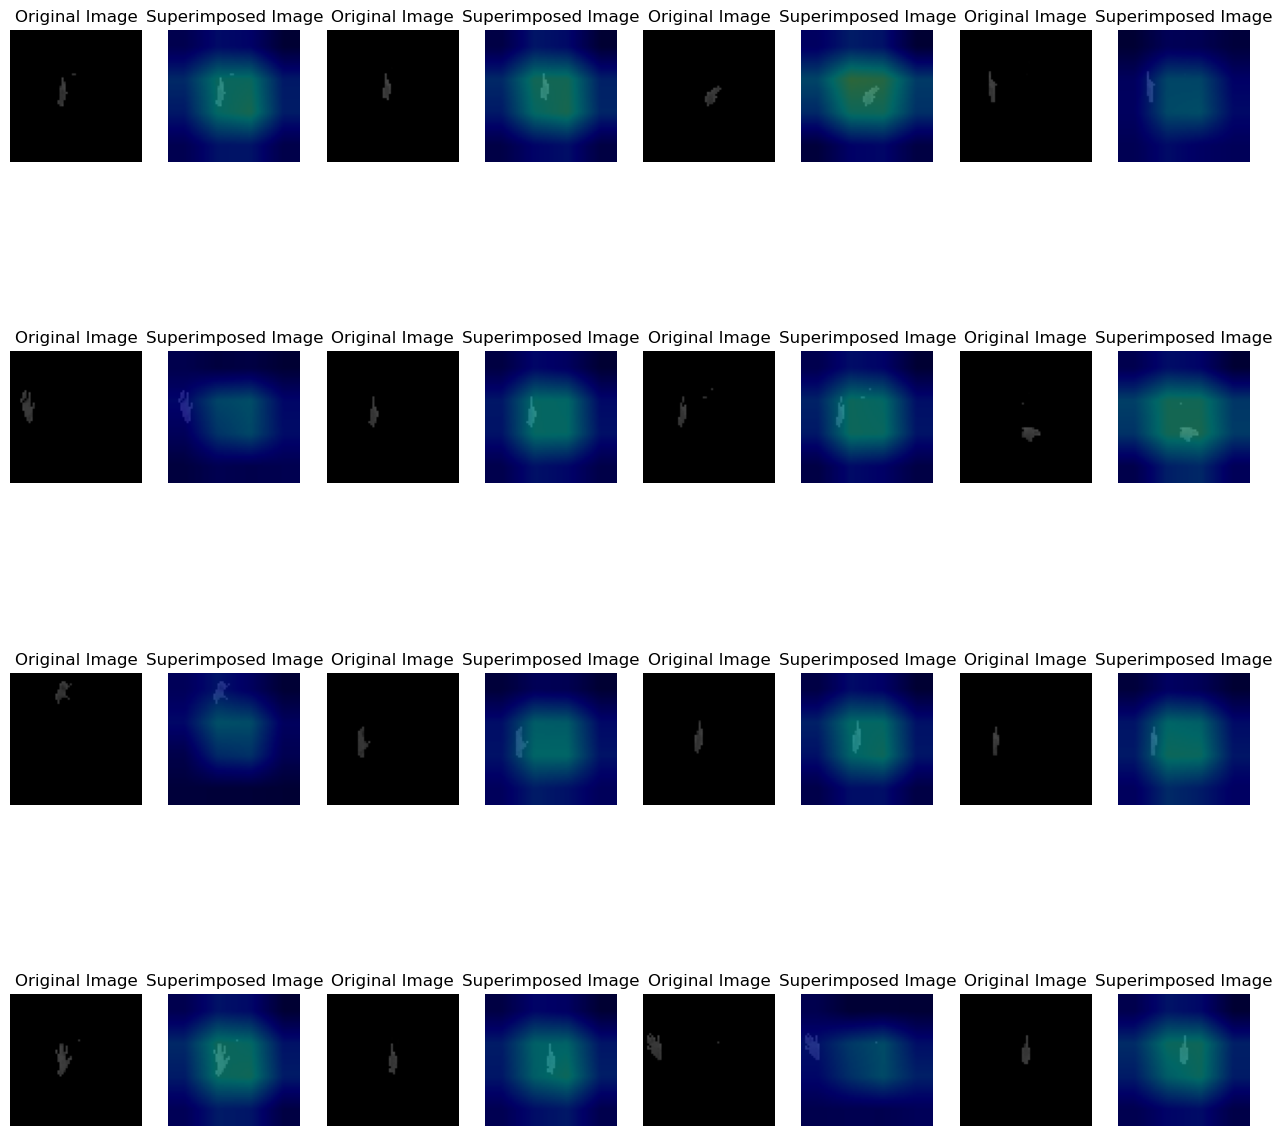

In [343]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
   
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.reduce_mean(heatmap, axis=-1)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    
    return heatmap.numpy()

def plot_gradcam(i_max, j_max, data_generator, model, layer_name):
    fig, axs = plt.subplots(i_max, j_max*2, figsize=(j_max*4, i_max*4))
    for i in range(i_max):
        for j in range(0, j_max*2, 2):
            batch = next(data_generator)
            img_array = batch[0][0:1]  
            original_img = np.uint8(255 * img_array[0])
            axs[i, j].imshow(original_img)
            axs[i, j].axis('off')
            axs[i, j].set_title('Original Image')
            
            heatmap = make_gradcam_heatmap(img_array, model, layer_name)
            heatmap = cv2.resize(heatmap, (img_array.shape[2], img_array.shape[1]))
            heatmap = np.uint8(255 * heatmap)
            heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
            superimposed_img = cv2.addWeighted(original_img, 0.6, heatmap, 0.4, 0)
            axs[i, j+1].imshow(superimposed_img)
            axs[i, j+1].axis('off')
            axs[i, j+1].set_title('Superimposed Image')
    plt.show()

last_layer_name = 'block5_conv3'
plot_gradcam(4, 4, train_generator, model4, last_layer_name)

We notice a consistent greenish pattern in the areas near the hand. This suggest that the model is able to assign more importance to these areas.